In [1]:
# !pip install pyMCFSimplex 
# !pip install gurobipy
# !pip install cvxpy

In [1]:
# !pip install pyMCFSimplex 
# !pip install gurobipy
# !pip install cvxpy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import time
from datetime import datetime
from time import process_time
from scipy.optimize import *
from scipy.optimize import minimize_scalar
from pyMCFSimplex import *
import cvxpy as cp

### 1. Generazione delle istanze del problema
La prima funzione *genera_Q(alpha, u, q, dimensione, p)* serve per generare i costi quadratici 
che si aggiungono ai costi lineari dell'istanza di MCF;
la stategia di generazione prevede di generare randomicamente (uniformemente) costi Qij "piccoli" o "grandi" rispetto ai costi lineari, 
come specificato dal parametro *alpha*. 

Permette inoltre di definire - tramite il parametro *p* - la proporzione di archi che hanno costo quadratico Qij nullo, 
abilitando la definizione e l'analisi anche di matrici semi-definite positive (0 &le; p &le; 1). 

La seconda funzione *leggi_file_dimacs(nome_file)* serve per estrarre le seguenti quantità: 
 - u, b, q
 - numero nodi
 - numero archi 

dal relativo file *.dmx*, generato [qui](https://commalab.di.unipi.it/datasets/mcf/). 

In [3]:
def genera_Q(alpha, u, q, dimensione, p):
    
    Q_diag = []

    for i in range(dimensione):
        Q_i = abs(random.uniform((-q[i] / u[i] * alpha), (q[i] / u[i] * alpha))) # generazione randomica 
        Q_diag.append(Q_i)

    Q = np.zeros((dimensione, dimensione))
    np.fill_diagonal(Q, Q_diag) # creazione matrice 

    num_entrate_zero = int(p * dimensione) 
    indici_zeri = np.random.choice(dimensione, num_entrate_zero, replace=False) # trova p*dimensione indici dei costi quadratici da mettere a zero 

    for idx in indici_zeri:
        Q[idx, idx] = 0
        # Q_diag[idx] = 0

    return Q #, Q_diag


def leggi_file_dimacs(nome_file):
    numero_nodi = 0
    numero_archi = 0
    u = []
    b = []
    q = []
    from_= []
    to_= []
    edges = []

    with open(nome_file, 'r') as file:
        for line in file:
            parts = line.split()
            if len(parts) > 0:
                if parts[0] == 'p':  # parts[0] è il primo carattere di ogni riga - nel formato standard DIMACS può essere c, p, n, a
                    # legge il numero di nodi e archi dal problema
                    numero_nodi = int(parts[2])
                    numero_archi = int(parts[3])
                    # inizializza il vettore di supply con zeri
                    b = [0] * numero_nodi
                elif parts[0] == 'n':
                    # legge i valori di supply per i nodi
                    nodo_id = int(parts[1])
                    supply = int(parts[2])
                    # assegna il valore di supply al nodo corrispondente
                    b[nodo_id - 1] = supply
                elif parts[0] == 'a':
                    # leggi l'arco e il suo cotso
                    from_node = int(parts[1])
                    to_node = int(parts[2])
                    max_capacity = int(parts[4])
                    costo = int(parts[5]) 
                    from_.append(from_node)
                    to_.append(to_node)
                    u.append(max_capacity)
                    q.append(costo)
                    edges.append((from_node , to_node ))

    return numero_nodi, numero_archi, np.array(u), b, np.array(q), edges,from_, to_

### 2. Implementazione dell'algoritmo FW tradizionale

#### Funzioni varie 

In [4]:
def showModuleFunctionality(mcf):
    vettore_soluzione = {}  
    nmx = mcf.MCFnmax()
    mmx = mcf.MCFmmax()
    pn = mcf.MCFnmax()
    pm = mcf.MCFmmax()

    pU = []
    caps = new_darray(mmx)
    mcf.MCFUCaps(caps)
    for i in range(0, mmx):
        pU.append(darray_get(caps, i))
    
    pC = []
    costs = new_darray(mmx)
    mcf.MCFCosts(costs)
    for i in range(0, mmx):
        pC.append(darray_get(costs, i))

    pDfct = []
    supply = new_darray(nmx)
    mcf.MCFDfcts(supply)
    for i in range(0, nmx):
        pDfct.append(darray_get(supply, i))

    pSn = []
    pEn = []
    startNodes = new_uiarray(mmx)
    endNodes = new_uiarray(mmx)
    mcf.MCFArcs(startNodes, endNodes)
    for i in range(0, mmx):
        pSn.append(uiarray_get(startNodes, i) + 1)
        pEn.append(uiarray_get(endNodes, i) + 1)

    #print("arc flow")
    length = mcf.MCFm()
    flow = new_darray(length)
    length = mcf.MCFn()
    nms = new_uiarray(length)
    mcf.MCFGetX(flow, nms)

   

    for i in range(0, length):
        if uiarray_get(nms, i)== 4294967295:
            break
        else:
       # print("flow", darray_get(flow, i), "arc", uiarray_get(nms, i))
            vettore_soluzione[uiarray_get(nms, i)] = darray_get(flow, i)

    return vettore_soluzione  # restituisce il vettore_soluzione alla fine della funzione

In [5]:
def visualize(k, f_val, alpha, prodotto_scalare, k_granularity, tempo, end, found_optimal): 

    ''' la funzione stampa un summary delle seguenti quantità ad ogni iterazione (oppure ogni 'k_granularity' iterazioni) :
     - iterazione corrente
     - step size, 
     - optimal solution, 
     - prodotto scalare 

     alla fine dell'esecuzione verrà mostrato :
     - prodotto scalare finale,
     - step size finale
     - numero totale di iterazioni
     - tempo di esecuzione totale 
    '''
    
    if end:
        print("_"*110)
        print("STOP: ")
        if found_optimal:
            print('Found optimal solution!')
        print('Final scalar product: {:>10.6f}  Final step size: {:>10.8f}  Total number iterations: {:>4}'.format(prodotto_scalare, alpha, k))
        print('Total running time: {:>10.2f} seconds'.format(tempo))    
        
    if  k % k_granularity == 0:
        print('Iteration: {:>4}   Step size: {:>10.8f}   Valore di f in x_k: {:>10.6f}   Scalar product grad, d: {:>10.2f} '.format(k, alpha, f_val, prodotto_scalare))
    return

In [6]:
def modify_dimacs(input_file_path, output_file_path, new_min, new_max, gradient):
    
    """
    Create a new DIMACS file with modified minflow values and gradients.

    Parameters:
    - input_file_path: Path to the original DIMACS file.
    - output_file_path: Path to the new DIMACS file with modified minflow values and gradients.
    - new_min: NumPy array containing the new minflow values for the arc descriptor lines.
    - gradient: NumPy array containing the gradient values for the arc descriptor lines.
    """
    with open(input_file_path, 'r') as file:
        lines = file.readlines()

    # Find the arc descriptor lines and update the minflow values, maxflow values, and gradients
    arc_lines = [line for line in lines if line.startswith('a ')]
    for i, line in enumerate(arc_lines):
        components = line.split()
        
        if len(components) == 6 and i < len(new_min):
            components[3] = str(float(new_min[i]))
            components[4] = str(float(new_max[i]))  
            components[-1] = str(gradient[i])
            arc_lines[i] = ' '.join(components) + '\n'


    modified_lines = lines.copy()
    for i, line in enumerate(modified_lines):
        if line.startswith('a '):
            modified_lines[i] = arc_lines.pop(0)

    with open(output_file_path, 'w') as new_file:
        new_file.writelines(modified_lines)

In [7]:
def line_search(x, d, gamma_max,func):
    
    def fun(gamma):
        ls = x + gamma*d
        return func(ls)

    res = minimize_scalar(fun, bounds=(0, gamma_max), method='bounded')

    gamma = res.x
    ls = x + gamma*d        
    return ls, gamma

In [8]:
class ProblemUnfeasibleError(Exception):
    pass

In [17]:
# away vertex
def away_step(grad, S):
    costs = {}
    
    for k,v in S.items():
        cost = np.dot(k,grad)
        costs[cost] = [k,v]
    vertex, alpha = costs[max(costs.keys())]  
    return vertex, alpha

# aggiornare active set come pseudocodice 
def update_S(S,gamma, Away, vertex):
    
    S = S.copy()
    vertex = tuple(vertex)
    
    if not Away:
        if vertex not in S.keys():
            S[vertex] = gamma
        else:
            S[vertex] *= (1-gamma)
            S[vertex] += gamma
            
        for k in S.keys():
            if k != vertex:
                S[k] *= (1-gamma)
    else:
        for k in S.keys():
            if k != vertex:
                S[k] *= (1+gamma)
            else:
                S[k] *= (1+gamma)
                S[k] -= gamma
    return {k:v for k,v in S.items() if np.round(v,3) > 0}


In [18]:
def visualize_bis(k, f_val, alpha, primal_gap_k, k_granularity): 

    # la funzione stampa un summary delle seguenti quantità ad ogni iterazione (oppure ogni 'k_granularity' iterazioni) :
    # - iterazione corrente
    # - step size, 
    # - optimal solution, 
    # - prodotto scalare 

    # alla fine dell'esecuzione verrà mostrato :
    # - prodotto scalare finale,
    # - step size finale
    # - numero totale di iterazioni
    # - tempo di esecuzione totale 
    
     if  k % k_granularity == 0:
        print('Iteration: {:>4}   Step size: {:>10.8f}   Valore di f in x_k: {:>10.6f}   Dual gap: {:>10.2f} '.format(k, alpha, f_val, primal_gap_k))
        return

#### 2a. Algoritmo FW trazionale

In [14]:
def FW(b,n,from_,to,f_tol, time_tol, 
              epsilon, Q, q, u, max_iter, numero_archi, x, tau,   # implementazione della trust region ex post 
              step_size_ottimo=True, visualize_res=True):
    
    ## inizializzazione delle variabili 
    k = 0
    alpha = 1
    dual_gap = []
    function_value = [func(x)]
    elapsed_time = [0]  
    tempo_per_it_MCF = [0]     
    tempi_per_it = [0] 
    f_improv = np.inf
    status = 'processing'
    bestlb = float('-inf')
    gap = float('-inf')
  
  
    while abs(f_improv) > f_tol and elapsed_time[-1] < time_tol:

        start = time.perf_counter() #contatore tempo 

        ## risoluzione del sottoproblema lineare usando solver MCF 
        
        gradient = (2 * np.dot(Q, x)) + q
        start_MCF = time.perf_counter()
        mcf = MCFSimplex()
        nmx     = n
        mmx     = numero_archi
        pn      = n
        pm      = numero_archi
        pU      = u.tolist()
        pC      = gradient.tolist()
        pDfct   = b
        pSn     = to
        pEn     = from_

        mcf.LoadNet(nmx, mmx, pn, pm, CreateDoubleArrayFromList(pU), CreateDoubleArrayFromList(pC),
                    CreateDoubleArrayFromList(pDfct), CreateUIntArrayFromList(pSn),
                    CreateUIntArrayFromList(pEn))
        
        mcf.SolveMCF()

        end_MCF = time.perf_counter()  
        tempo_per_it_MCF.append(end_MCF - start_MCF)  
        ## fine della risoluzione del sottoproblema lineare

        if mcf.MCFGetStatus() != 0:
            raise ProblemUnfeasibleError("The problem is unfeasible!")

        # recupero x ottima lineare (che chiamerò v)
        vettore_soluzione = showModuleFunctionality(mcf)
        sol_x = np.zeros(numero_archi)
        for key, value in vettore_soluzione.items():
            sol_x[key] = value
        v = sol_x.copy()
        

        # TRUST REGION STABILIZATION EX POST
        u = np.array(u)
        if tau > 0 and k > 1: 
            # calcolo lower bound e upper bound della trust region 
            ub_trust = x + tau * u
            lb_trust = x - tau * u 
            v = np.maximum(lb_trust, np.minimum(v, ub_trust))

        d = v - x  # direzione 

        lb = func(x) + np.dot(gradient, d)   # lower bound 
        if lb > bestlb:
            bestlb = lb
        gap = (func(x) - bestlb) / max(abs(func(x)), 1)  # relative gap
        dual_gap.append(gap)


        if visualize_res and k > 0:
            print(f'iter: {k}, f value = {function_value[-1]}, fbest = {func(x):.8e}, gap = {dual_gap[-1]:.4e}')

        # vari check terminazione 
        if abs(gap) <= epsilon:  
            status = 'found optimal'
            break
        
        if k == max_iter:
            status = 'stopped (max_iter)'
            print(status)
            break
        
        # aggiornamento della posizione 
        if step_size_ottimo:
            x, alpha = line_search(x, d, 1, func)
        else:
            alpha = 2 / (2 + k)
            x = x + alpha * d

        if not np.all((0 <= x) & (x <= u)):
            status = 'unfeasible because of trust region'
            print(status)
            break

        end = time.perf_counter()
        tempo_it = end - start
        tempi_per_it.append(tempo_it)
        elapsed_time.append(elapsed_time[k] + tempo_it) 
        
        f_improv = function_value[-1] - func(x) # inutile non guardare 
        function_value.append(func(x))
        
        k += 1 # aggiorno k 

        if abs(f_improv) < f_tol:  # aggiornamento status
            status = 'stopped (f_tol)'
        if elapsed_time[-1] > time_tol:
            status = 'stopped (time_tol)'

    print('Status:', status)
    print('Final gap duale: {:>10.6f}  Final step size: {:>10.8f}  Total number iterations: {:>4}'.format(dual_gap[-1], alpha, k))
    print('fbest:', func(x))
    print('Total running time: ', sum(tempi_per_it))
    
    return x, function_value, elapsed_time, dual_gap, k, tempi_per_it, tempo_per_it_MCF, status


In [9]:
def FW_exante(b,n,from_,to,f_tol, time_tol, epsilon, Q, q, u, tau, max_iter, numero_archi, x, step_size_ottimo=True, visualize_res=True):
    
    k = 0
    dual_gap = []
    function_value = [func(x)]
    elapsed_time = [0]  
    tempo_per_it_MCF = [0]     
    tempi_per_it = [0] 
    f_improv = np.inf
    status = 'processing'
    bestlb = float('-inf')
    lb_trust = np.zeros(numero_archi).astype('float64')
    ub_trust = np.array(u).astype('float64')
    alpha = 1
    pDfct   = b

    while abs(f_improv) > f_tol and elapsed_time[-1] < time_tol:

        if tau > 0 and k >1: 
            lb_trust = np.maximum(0, sol_x - tau * u).astype('float64')
            ub_trust = np.minimum(u,sol_x + tau * u).astype('float64')
        start = time.perf_counter()

        gradient = (2 * np.dot(Q, x)) + q
        start_MCF = time.perf_counter()
        mcf = MCFSimplex()
        nmx     = n
        mmx     = numero_archi
        pn      = n
        pm      = numero_archi
        pU      = ub_trust
        pC      = gradient 
        #pDfct   = b
        pSn     = to
        pEn     = from_
        pU      -= lb_trust
        pU      = pU.tolist()

        for index, el in enumerate(pEn):
            pDfct[el-1] = pDfct[el-1] - lb_trust[index]
        for index, el in enumerate(pSn):
             pDfct[el-1] = pDfct[el-1] + lb_trust[index]

        mcf.LoadNet(nmx, mmx, pn, pm, CreateDoubleArrayFromList(pU), CreateDoubleArrayFromList(pC),
                    CreateDoubleArrayFromList(pDfct), CreateUIntArrayFromList(pSn),
                    CreateUIntArrayFromList(pEn))

        mcf.SolveMCF()

        end_MCF = time.perf_counter()  
        tempo_per_it_MCF.append(end_MCF - start_MCF)  

        if mcf.MCFGetStatus() != 0:
            raise ProblemUnfeasibleError("The problem is unfeasible!")

        vettore_soluzione = showModuleFunctionality(mcf)
        sol_x = [0] * numero_archi
  
        for key in vettore_soluzione:
            sol_x[key] = vettore_soluzione[key]
        sol_x = sol_x - lb_trust
        sol_x -= lb_trust
        v = np.array(sol_x)
        d = v - x

        if visualize_res and k > 0:
            print(f'iter: {k}, f value = {function_value[-1]}, fbest = {func(x):.8e}, gap = {dual_gap[-1]:.4e}')


        lb = func(x)+ np.dot(gradient, v - x)  
        if lb > bestlb:
            bestlb = lb
        gap = (func(x) - bestlb) / max(abs(func(x)), 1)  # relative gap

        dual_gap.append(gap)

        if abs(gap) <= epsilon:  
            status = 'found optimal'
            break
        
        if k == max_iter:
            status = 'stopped (max_iter)'
            print(status)
            break
        
        if step_size_ottimo:
            x, alpha = line_search(x, d, 1, func)
        else:
            alpha = 2 / (2 + k)
            x = x + alpha * d

        end = time.perf_counter()
        tempo_it = end - start
        tempi_per_it.append(tempo_it)
        elapsed_time.append(elapsed_time[k] + tempo_it) 
        
        f_improv = function_value[-1] - func(x)
        function_value.append(func(x))
        
        k += 1

        if abs(f_improv) < f_tol:
            status = 'stopped (f_tol)'
            print(status)
            break
        if elapsed_time[-1] > time_tol:
            status = 'stopped (time_tol)'
            print(status)
            break

    print('Status:', status)
    print('Final gap duale: {:>10.6f}  Final step size: {:>10.8f}  Total number iterations: {:>4}'.format(dual_gap[-1], alpha, k))
    print('fbest:', func(x))
    print('Total running time: ', sum(tempi_per_it))

    return x, function_value, elapsed_time, dual_gap, k, tempi_per_it, tempo_per_it_MCF, status

#### 2b. Algoritmo FW variante - AWAY STEP

#### Funzioni varie

In [19]:

def AFW(epsilon, max_iter, Q, q, numero_archi,func, x,  n, u, b, to, from_, visualize_res=True):
    
    k = 0    
    bestlb = -np.inf
    gamma = 1
    tempo_tot = 0
    status = 'processing'
    f_values = []
    tempi_per_it = [0]
    gap = []
    dual_gap = []
    elapsed_time = [0]  
    tempo_per_it_MCF = [0]  
    f_improv = np.inf
    tempi_per_it = [0]  
  
    S = {tuple(np.array(x)): 1} # active set inizializzazione
   

    while abs(f_improv) > f_tol and elapsed_time[-1] < time_tol:

        start = time.perf_counter()

        f_values.append(func(x))

        # STEP 1 : calcolo gradiente
        gradient = (2 * np.dot(Q, x)) + q

        mcf = MCFSimplex()
        start_MCF = time.perf_counter()  
        nmx     = n
        mmx     = numero_archi
        pn      = n
        pm      = numero_archi
        pU      = u.tolist()
        pC      = gradient.tolist()
        pDfct   = b
        pSn     = to
        pEn     = from_
     
        mcf.LoadNet(nmx, mmx, pn, pm, CreateDoubleArrayFromList(pU), CreateDoubleArrayFromList(pC),
            CreateDoubleArrayFromList(pDfct), CreateUIntArrayFromList(pSn),
            CreateUIntArrayFromList(pEn))
        
        mcf.SolveMCF()

        end_MCF = time.perf_counter() 
        tempo_per_it_MCF.append(end_MCF - start_MCF)  

        if mcf.MCFGetStatus() != 0:
            raise ProblemUnfeasibleError("The problem is unfeasible!")

        vettore_soluzione = showModuleFunctionality(mcf)
        sol_x = [0] * numero_archi

        for key in vettore_soluzione:
            sol_x[key] = vettore_soluzione[key]

        # calcolo delle x_bar e determinazione della direzione di ricerca
        v = sol_x.copy()
        d_FW = v - x
        
        # calcolo away vertex e direzione d_A 
        a, alpha_a = away_step(gradient, S)
        d_A = x - a
       
        # check se FW gap è maggiore dell'away gap --> per capire quale passo usare 
        if np.dot(-gradient, d_FW) >= np.dot(-gradient, d_A):
            # scegliamo FW direction
            d = d_FW
            vertex = v
            gamma_max = 1
            Away = False
        else:
            # scegliamo Away direction
            d = d_A
            vertex = a
            gamma_max = alpha_a/(1-alpha_a)

        if visualize_res and k > 0:
            #visualize_bis(k, function_value[-1], alpha, primal_gap[-1], k_granularity=1)
            print(f'iter: {k} iter, fval = {f_values[-1]}, fbest = {func(x):.8e}, gap = {dual_gap[-1]:.4e}')
        
        lb = func(x)+ np.dot(np.array(gradient), np.array(d))  # Compute the lower bound
       
        if lb > bestlb:
            bestlb = lb
        
        gap = (func(x) - bestlb)/ max(abs(func(x)), 1)  # relative gap
        dual_gap.append(gap)
        
        if gap <= epsilon:  
            status = 'found optimal'
            print(status)
            break
        if k == max_iter:
            status = 'stopped (max_iter)'
            print(status)
            break

        # ricerca di x_new e gamma usando line search 
        x, gamma = line_search(x,d, gamma_max, func)

        # aggiornamento active set
        S = update_S(S,gamma, Away, vertex)

   
        end = time.perf_counter()
        tempo_it = end - start
        tempi_per_it.append(tempo_it)
        elapsed_time.append(elapsed_time[k] + tempo_it)  
        f_improv = f_values[-1] - func(x)
        f_values.append(func(x))
        
        k+=1

        if abs(f_improv) < f_tol:
            status = 'stopped (f_tol)'
            print(status)
            break

        if elapsed_time[-1] > time_tol:
            status = 'stopped (time_tol)'
            print(status)
            break
        
         

    print('Status:', status)
    print()
    print('Final gap duale: {:>10.6f}  Final step size: {:>10.8f}  Total number iterations: {:>4}'.format(dual_gap[-1], gamma, k))
    if status == 'found optimal':
        ('Optimal solution:', func(x))
    print('Total running time: ', sum(tempi_per_it))

    return f_values, k, tempo_tot, tempi_per_it, x, dual_gap, tempo_per_it_MCF, elapsed_time

### PROVE ALGORITMI: esperimenti e grafici vari 

In [ ]:
## PROVA FW TRADIZIONALE

func = lambda x: np.dot(x, np.dot(Q, x))+np.dot(q,x)
nome_file_dmx ='1000/netgen-1000-1-2-a-b-s.dmx'
n, numero_archi, u, b, q, _, from_ , to = leggi_file_dimacs(nome_file_dmx)
a = 100
Q = genera_Q(a, u, q, numero_archi, 0.3)
x_0 = u/2   
f_tol = 1e-9
time_tol = np.inf
epsilon = 1e-4
max_iter = 1000
tau = 0.0
x, function_value, elapsed_time, dual_gap, k, tempi_per_it, tempo_per_it_MCF, status = FW(b,n,from_,to,f_tol, time_tol, epsilon, Q, q, u,
                                                                                                 max_iter, numero_archi, x_0, tau)


In [ ]:
func = lambda x: np.dot(x, np.dot(Q, x))+np.dot(q,x)
#nome_file_dmx ='1000/netgen-1000-1-2-a-b-s.dmx'
nome_file_dmx = '1000/netgen-1000-1-3-a-b-s.dmx'
n, numero_archi, u, b, q, _, from_ , to = leggi_file_dimacs(nome_file_dmx)
a = 100
Q = genera_Q(a, u, q, numero_archi, 0.5)
x_0 = u/2   
f_tol = 1e-9
time_tol = np.inf
epsilon = 1e-4
max_iter = 2000


tau_values = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]

gap_results = []
function_values = []
tempi_iter_results = []
best_function_values = []

for tau in tau_values:
    x, function_value, elapsed_time, dual_gap, k, tempi_per_it, tempo_per_it_MCF, status = FW(b, n, from_, to, f_tol, time_tol, epsilon, Q, q, u, max_iter, numero_archi, x_0, tau, visualize_res=False)
    gap_results.append(dual_gap)
    best_function_value = function_value[-1]
    function_values.append(function_value)  
    best_function_values.append(best_function_value)
    tempi_iter_results.append(tempi_per_it)


In [42]:
np.save('Q.npy', Q)
k_summary = [len(el)-1 for el in tempi_iter_results]
tempo_tot = [sum(lista) for lista in tempi_iter_results]
d = {'tau': tau_values, 'k tot': k_summary, 'best f value': best_function_values, 'tempo_tot': tempo_tot}
results_df = pd.DataFrame(data = d)
results_df

,tau,k tot,best f value,tempo_tot
0,0.0,1241,22467.004418,15.586508
1,0.1,2000,21010.150932,40.220942
2,0.3,2000,22001.318774,85.817996
3,0.5,2000,22301.846263,82.590566
4,0.7,33,22438.225918,0.860695
5,0.9,819,22466.539903,26.700520


In [ ]:
plt.style.use('ggplot')
for i, tau in enumerate(tau_values):
    plt.plot(gap_results[i], label=f'tau = {tau}, fbest = {best_function_values[i]:.4e}')

plt.yscale('log')

plt.xlabel('iter (k)', fontsize=14)
plt.ylabel('gap', fontsize=14)
plt.title('Convergence of Dual Gap for Different Tau Values', fontsize=14)
plt.legend()

plt.show()

In [44]:
# confronto con altro solver (cvxpy)

nome_file_dmx = '1000/netgen-1000-1-3-a-b-s.dmx'
n, numero_archi, u, b, q, _, from_ , to = leggi_file_dimacs(nome_file_dmx)
Q = np.load('Q.npy')
E = np.zeros((n, numero_archi))

for j in range(numero_archi):
    i_entrante = to[j]
    i_uscente = from_[j]
    E[i_entrante - 1, j] = -1  
    E[i_uscente - 1, j] = 1    

n = len(q)
x = cp.Variable(n)

objective = cp.Minimize(cp.quad_form(x, Q) + q @ x) # funzione obiettivo 

constraints = [E @ x == b, 0 <= x, x <= u]  #definizione vincoli 

problem = cp.Problem(objective, constraints)

problem.solve()

if problem.status == cp.OPTIMAL:
    print('soluzione ottimale trovata!')
    print('valore ottimo della funzione obiettivo =', problem.value)
    # print('valori delle variabili x:')
    # print(x.value)
else:
    print('nessuna soluzione ottimale trovata.')



soluzione ottimale trovata!
valore ottimo della funzione obiettivo = 22466.202251928007


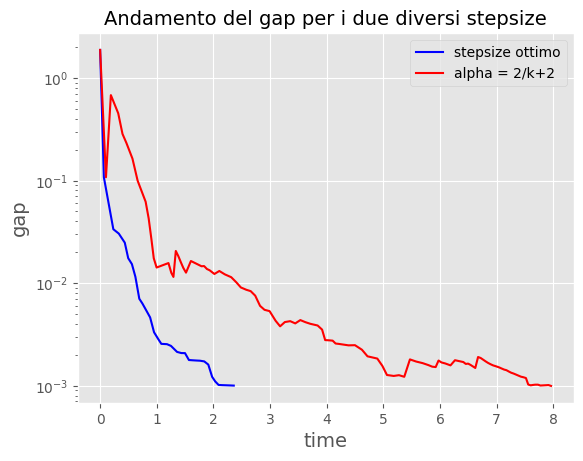

In [25]:
# PLOT DELLO STEPSIZE in f(time)
plt.style.use('ggplot')
plt.plot(elapsed_time, dual_gap, label = 'stepsize ottimo', color = 'blue')
plt.plot(elapsed_time_nonopt, dual_gap_nonopt, label='alpha = 2/k+2', color = 'red')

plt.ylabel ('gap',  fontsize = 14)
plt.xlabel('time',  fontsize = 14)
plt.yscale('log')
plt.title('Andamento del gap per i due diversi stepsize', fontsize = 14)
plt.legend()
plt.show()

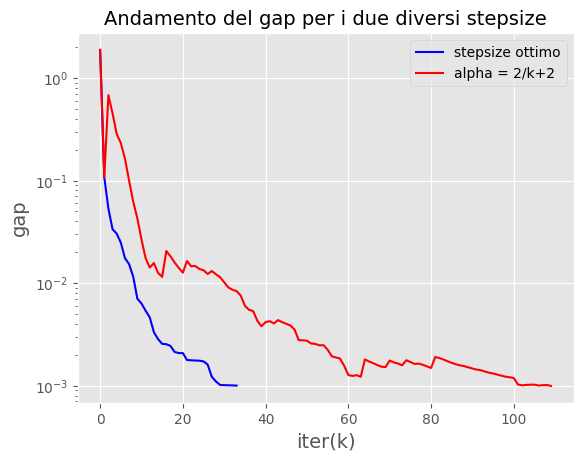

In [27]:
# PLOT DELLO STEPSIZE in f(k)
plt.style.use('ggplot')
plt.plot(list(range(k+1)), dual_gap, label = 'stepsize ottimo', color = 'blue')
plt.plot(list(range(k_nonopt+1)), dual_gap_nonopt, label='alpha = 2/k+2', color = 'red')

plt.ylabel ('gap',  fontsize = 14)
plt.xlabel('iter(k)',  fontsize = 14)
plt.yscale('log')
plt.title('Andamento del gap per i due diversi stepsize', fontsize = 14)
plt.legend()
plt.show()

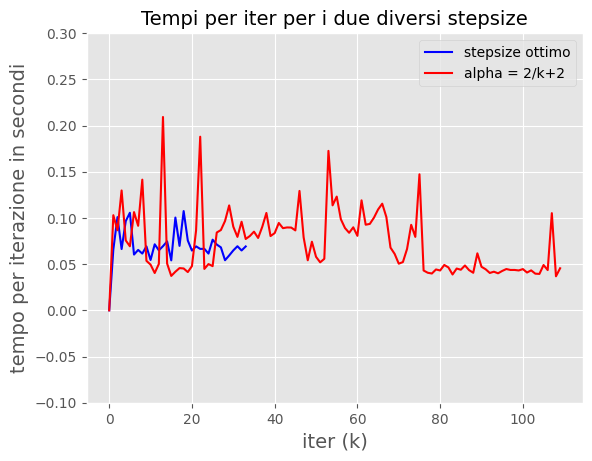

In [46]:
# ANALISI DEL TEMPO PER OGNI ITERAZIONE 
plt.style.use('ggplot')
plt.plot(list(range(k+1)), tempi_per_it, label = 'stepsize ottimo', color = 'blue')
plt.plot(list(range(k_nonopt+1)), tempi_per_it_nonopt, label='alpha = 2/k+2', color = 'red')

plt.ylabel ('tempo per iterazione in secondi',  fontsize = 14)
plt.xlabel('iter (k)',  fontsize = 14)
# plt.yscale('log')
plt.ylim(-0.1, 0.30)
plt.title('Tempi per iter per i due diversi stepsize', fontsize = 14)
plt.legend()
plt.show()

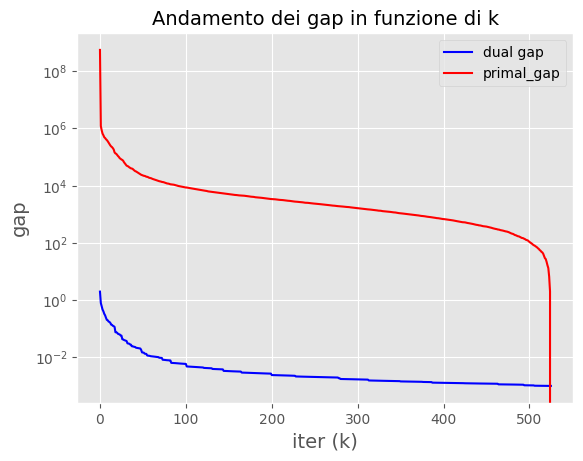

In [81]:
# DUAL E PRIMAL GAP : plot per mostrare che il primo è un UB per il secondo 
plt.plot(list(range(k+1)), dual_gap, label = 'dual gap', color = 'blue')
fstar = func(x)
primal = function_value - fstar
plt.plot(list(range(k+1)), primal, label='primal_gap', color = 'red')

plt.ylabel ('gap',  fontsize = 14)
plt.xlabel('iter (k)',  fontsize = 14)
plt.yscale('log')
plt.title('Andamento dei gap in funzione di k', fontsize = 14)
plt.legend()
plt.show()

In [82]:
# TABELLA DIFFERENZA STEPSIZES
folder_path = r'C:\Users\Valeria\Documents\GitHub\Optimization\1000' # path assoluto della cartella 1000
esperimenti = []
file_names = os.listdir(folder_path)

for file_name in file_names:
    if file_name.endswith('.dmx'):
        file_path = os.path.join(folder_path, file_name)
        relative_path = os.path.relpath(file_path, os.getcwd())
        esperimenti.append(relative_path)

In [106]:

data = {
    'nome_file_dmx': [],
    'iter_optimal': [],
    'iter_non_optimal': [],
    'time_optimal': [],
    'time_non_optimal': []
}

a = 1000
p = 0.5
Q = genera_Q(a, u, q, numero_archi, p)

for nome_file_dmx in esperimenti[:14]:
    func = lambda x: np.dot(x, np.dot(Q, x)) + np.dot(q, x)

    n, numero_archi, u, b, q, _, from_, to = leggi_file_dimacs(nome_file_dmx)
    x_0 = u / 2
    f_tol = 1e-9
    time_tol = np.inf
    epsilon = 1e-3
    tau1 = 0.0
    max_iter = 2000

    try:
        x, _, elapsed_time, _, k, _, _, _ = FW_trad_modificato(b, n, from_, to, f_tol, time_tol, epsilon, Q, q, u, tau1, max_iter, numero_archi, x_0, step_size_ottimo=True, visualize_res=False)
    except ProblemUnfeasibleError as e:
        continue

    try:
        x_nonopt, _, elapsed_time_nonopt, _, k_nonopt, _, _, _ = FW_trad_modificato(b, n, from_, to, f_tol, time_tol, epsilon, Q, q, u, tau1, max_iter, numero_archi, x_0, step_size_ottimo=False, visualize_res=False)
    except ProblemUnfeasibleError as e:
        continue

    updated_nome_file_dmx = nome_file_dmx.replace('1000\\', '')
    data['nome_file_dmx'].append(updated_nome_file_dmx)
    data['iter_optimal'].append(k)
    data['iter_non_optimal'].append(k_nonopt)
    data['time_optimal'].append(elapsed_time[-1])
    data['time_non_optimal'].append(elapsed_time_nonopt[-1])

df = pd.DataFrame(data)

Status: found optimal

Final gap duale:   0.000987  Final step size: 0.00052747  Total number iterations:   20
fbest: 498130.2528529737
Total running time:  0.7379281999983505
Status: found optimal

Final gap duale:   0.000999  Final step size: 0.01226994  Total number iterations:  162
fbest: 498201.4133990981
Total running time:  3.7583297999917704
Status: found optimal

Final gap duale:   0.000784  Final step size: 0.00022288  Total number iterations:   47
fbest: 18778.650672989876
Total running time:  1.5081209999998464
Status: found optimal

Final gap duale:   0.000998  Final step size: 0.00207900  Total number iterations:  961
fbest: 18777.073622489894
Total running time:  19.320752000002358
Status: found optimal

Final gap duale:   0.000997  Final step size: 0.00561663  Total number iterations:  458
fbest: 266005.1876818575
Total running time:  12.97780519999742
Status: found optimal

Final gap duale:   0.000949  Final step size: 0.00425532  Total number iterations:  469
fbest: 2

Status: found optimal

Final gap duale:   0.000927  Final step size: 0.00377741  Total number iterations:   93
fbest: 120469.73179571677
Total running time:  2.9710076000137633
Status: found optimal

Final gap duale:   0.000956  Final step size: 0.01000000  Total number iterations:  199
fbest: 120426.57178641603
Total running time:  4.135201199980656


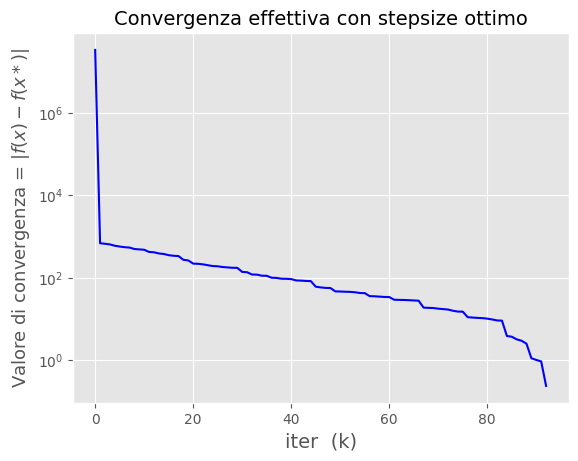

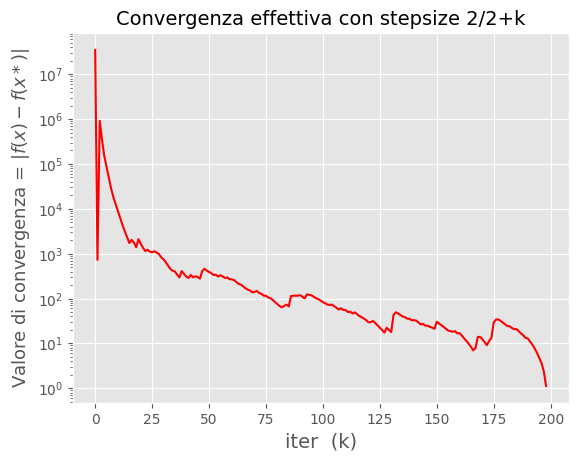

Status: found optimal

Final gap duale:   0.000997  Final step size: 0.00630943  Total number iterations:  364
fbest: 78392.08332527523
Total running time:  10.509585800009518
Status: found optimal

Final gap duale:   0.000914  Final step size: 0.00537634  Total number iterations:  371
fbest: 78347.2536197991
Total running time:  7.9721129999797995


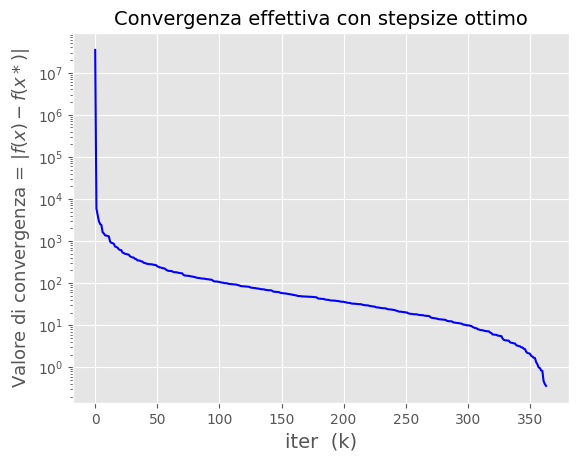

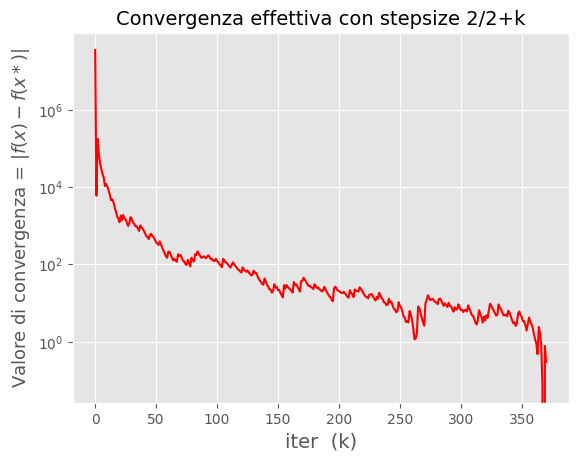

Status: found optimal

Final gap duale:   0.000997  Final step size: 0.00073540  Total number iterations:  238
fbest: 52314.41576180335
Total running time:  7.050454099975468
Status: found optimal

Final gap duale:   0.000908  Final step size: 0.00913242  Total number iterations:  218
fbest: 52287.43899453699
Total running time:  4.914605299985851


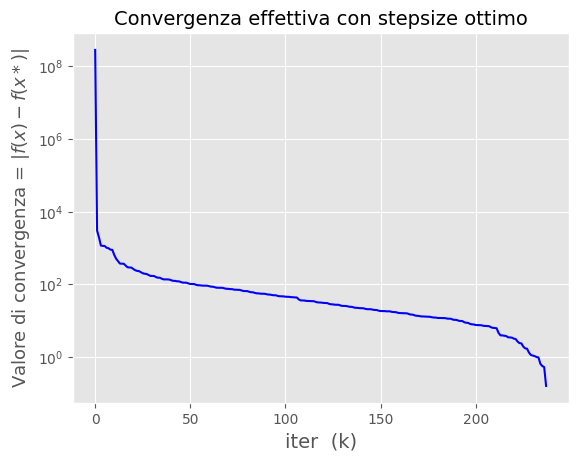

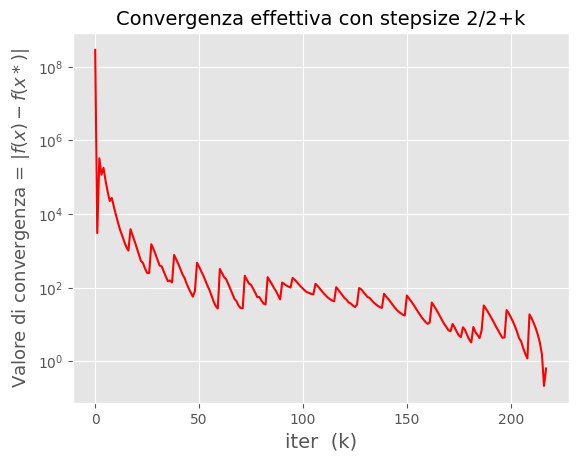

In [127]:
a = 100
p = 0.5
Q = genera_Q(a, u, q, numero_archi, p)

for nome_file_dmx in esperimenti[4:9]:
    func = lambda x: np.dot(x, np.dot(Q, x)) + np.dot(q, x)

    n, numero_archi, u, b, q, _, from_, to = leggi_file_dimacs(nome_file_dmx)
    x_0 = u / 2
    f_tol = 1e-9
    time_tol = np.inf
    epsilon = 1e-3
    tau1 = 0.0
    max_iter = 2000

    try:
        x, function_value, elapsed_time, _, k, _, _, _ = FW_trad_modificato(b, n, from_, to, f_tol, time_tol, epsilon, Q, q, u, tau1, max_iter, numero_archi, x_0, step_size_ottimo=True, visualize_res=False)
    except ProblemUnfeasibleError as e:
        continue

    try:
        x_nonopt, function_value_nonopt, elapsed_time_nonopt, _, k_nonopt, _, _, _ = FW_trad_modificato(b, n, from_, to, f_tol, time_tol, epsilon, Q, q, u, tau1, max_iter, numero_archi, x_0, step_size_ottimo=False, visualize_res=False)
    except ProblemUnfeasibleError as e:
        continue
    
    fstar_opt = func(x)
    fstar_nonopt = func(x_nonopt)
    _, _, u, _, _, _, _ , _ = leggi_file_dimacs(nome_file_dmx)
    Q_diag = np.diag(Q)

    convergence_values = []  # valori di convergenza teorica
    convergence_values_nonopt = []

    # simulo i dati teorici (convergenza teorica)
  
    plt.plot(list(range(k)), function_value[:k] - fstar_opt, linestyle='-', color = 'blue')
    plt.yscale("log") 
    # plt.ylim(1e-1, 1e13)
    plt.xlabel("iter  (k)", fontsize = 14)
    plt.ylabel(r'Valore di convergenza = $|f(x) - f(x*)|$', fontsize = 13)
    plt.title('Convergenza effettiva con stepsize ottimo', fontsize = 14)
    plt.grid(True)

    plt.show()


    
    plt.plot(list(range(k_nonopt)), function_value_nonopt[:k_nonopt] - fstar_nonopt, label="Convergenza Effettiva" , linestyle='-', color = 'red')
    plt.yscale("log") 
    # plt.ylim(1e-1, 1e13)
    plt.xlabel("iter  (k)", fontsize = 14)
    plt.ylabel(r'Valore di convergenza = $|f(x) - f(x*)|$', fontsize = 13)
    
 
    plt.title("Convergenza effettiva con stepsize 2/2+k", fontsize = 14)
    plt.grid(True)

    plt.show()

    
    

### 3. Funzioni per PLOT


In [13]:
# queste due funzioni plottano il FW (dual) gap e il primal gap 

def plot_dual_gap(gap_fw, gap_afw, axes):
    
    gap_fw = np.abs(gap_fw)
    gap_afw = np.abs(gap_afw)
    iterazioni_fw = list(range(1, len(gap_fw) + 1))
    iterazioni_afw = list(range(1, len(gap_afw) + 1))

    plt.style.use('ggplot')
    # plt.figure(figsize=(8, 6))
    axes[0].plot(iterazioni_fw, gap_fw, color = 'lightseagreen', label = 'FW')
    axes[0].plot(iterazioni_afw, gap_afw, color = 'darkred', label = 'AFW')
    axes[0].set_xlabel('Iterazioni (k)', fontsize= 10)
    axes[0].set_yscale('log')
    axes[0].set_ylabel(r'dual gap = $|<grad(f), d>|$', fontsize=10)
    
    axes[0].set_title('Andamento del Dual Gap (aka FW Gap) in funzione di k', fontsize=11)
    axes[0].legend(fontsize='small', loc='upper right')
    plt.grid(True)

    # plt.show()


def plot_primal_gap(f_values_fw, xstar_fw, found_optimal_fw, f_values_afw, xstar_afw, found_optimal_afw, axes):   
    # f(x) - f(x*)

    # check iniziale:  
    # se l'algoritmo ha trovato x ottima (ie il criterio di stop verificato è quello sul gap, non su max iter)
    # allora ha senso calcolare f(x*)
    if found_optimal_fw and found_optimal_afw:

        xstar_fw = np.array(xstar_fw)
        xstar_afw = np.array(xstar_afw)
        fxstar_fw = xstar_fw.T @ Q @ xstar_fw + q @ xstar_fw
        fxstar_afw = xstar_afw.T @ Q @ xstar_afw + q @ xstar_afw
        gap_fw = np.abs(f_values_fw - fxstar_fw)
        gap_afw = np.abs(f_values_afw - fxstar_afw)
        iterazioni_fw = list(range(1, len(f_values_fw) + 1))
        iterazioni_afw = list(range(1, len(f_values_afw) + 1))
        
        plt.style.use('ggplot')
        #plt.figure(figsize=(8, 6))
        axes[1].plot(iterazioni_fw, gap_fw, color = 'lightseagreen', label = 'FW')
        axes[1].plot(iterazioni_afw, gap_afw, color = 'darkred', label = 'AFW')
        axes[1].set_xlabel('Iterazioni (k)', fontsize=10)
        axes[1].set_yscale('log')
        axes[1].set_ylabel(r'primal gap = $|f(x) - f(x*)|$', fontdict={'style': 'italic', 'fontsize':10})
        
        axes[1].set_title('Andamento del Primal Gap in funzione di k', fontsize=11)
        axes[1].legend(fontsize='small', loc='upper right')
        
        plt.grid(True)

        # plt.show()
        
    else: 
        ('primal gap non disponibile')

In [ ]:
def plot_dual_gap_bis(gap_fw, gap_afw, p, alpha): # senza axes 
    
    gap_fw = np.abs(gap_fw)
    gap_afw = np.abs(gap_afw)
    iterazioni_fw = list(range(1, len(gap_fw) + 1))
    iterazioni_afw = list(range(1, len(gap_afw) + 1))

    plt.style.use('ggplot')
    plt.figure(figsize=(8, 6))
    plt.plot(iterazioni_fw, gap_fw, color = 'lightseagreen', label = 'FW')
    plt.plot(iterazioni_afw, gap_afw, color = 'darkred', label = 'AFW')
    # axes[0].axhline(y = 0.0001, color='red', linestyle='--', label='Valore stop epsilon')
    plt.xlabel('Iterazioni (k)', fontsize= 12)
    plt.yscale('log')
    plt.ylabel(r'dual gap = $|<grad(f), d>|$', fontsize=12)
    # plt.xticks(iterazioni_fw)
    plt.title('Andamento del FW Gap in funzione di k - p={}, alpha={}'.format(p, alpha), fontsize=14)
    plt.legend(fontsize='small', loc='upper right')
    plt.grid(True)

    plt.show()


In [15]:
# l'obiettivo di questa funzione è mostrare che effettivamente il FW gap (dual gap) costituisce un upper bound al primal gap


def plot_dual_and_primal_gap(f_values, dual_gap, xstar):
    dual_gap = np.abs(dual_gap)
    iterazioni = list(range(1, len(dual_gap) + 1))
    
    plt.style.use('ggplot')
    plt.figure(figsize=(8, 6))
    
    plt.plot(iterazioni, dual_gap, color='lightseagreen', label='Dual Gap (aka FW Gap)')
    
    xstar = np.array(xstar)
    fxstar = xstar.T @ Q @ xstar + q @ xstar
    primal_gap = np.abs(f_values - fxstar)
    plt.plot(iterazioni, primal_gap, color='dodgerblue', label='Primal Gap')
    
    plt.xlabel('Iterazioni (k)')
    plt.ylabel('Gap', fontdict={'style': 'italic'})
    
    plt.title('Andamento del Dual Gap e del Primal Gap in funzione di k - 1000 nodi', fontsize=12)
    plt.legend()
    plt.grid(True)

    plt.show()


In [75]:
# questa funzione plotta un grafico di convergenza: 
# viene mostrato l'andamento della convergenza teorica e reale per FW tradizionale
# conv teorica  :  f(x)-f(x^*) <=  2LD^2 / (k+3)
def plot_convergenza(f_values, k_tot, Q, nome_file_dmx, xstar, a):
    
    fstar = func(xstar)
    _, _, u, _, _, _, _ , _ = leggi_file_dimacs(nome_file_dmx)
    Q_diag = np.diag(Q)

    # l'autovalore massimo di Q è la costante di convergenza L 
    L = np.max(Q_diag)
    # il diametro dello spazio D è la norma del vettore u 
    D = np.linalg.norm(u) 

    k_values = []  # valori di k (iterazione)
    convergence_values = []  # valori di convergenza teorica

    # simulo i dati teorici (convergenza teorica)
    for k in range(1, k_tot + 1):
        k_values.append(k)
        convergence_values.append((2 * L * D**2) / (k + 3))  # formula converg teorica
    plt.style.use('ggplot')
 
    plt.plot(k_values, convergence_values, label="Convergenza Teorica", linestyle='--', color = 'red')
    plt.plot(k_values, f_values[:k_tot]-fstar, label="Convergenza Effettiva" , linestyle='-', color = 'blue')
    plt.yscale("log") 
    plt.ylim(1e-1, 1e13)
    plt.xlabel("iter  (k)", fontsize = 14)
    plt.ylabel(r'Valore di convergenza = $|f(x) - f(x*)|$', fontsize = 13)
    
    plt.legend()
    plt.title('Convergenza teorica vs effettiva - alpha = {}'.format(a), fontsize = 14)
    plt.grid(True)

    plt.show()

    return